Dependencies

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings 
warnings.filterwarnings('ignore')
plt.style.use('fivethirtyeight') 

# Regression coefficient confidence intervals

Let’s start by creating a set of x-values (or “input variables”, “predictors”, “features”)

In [3]:
ndata = 10000
x= np.linspace(-10,10,num=ndata)

That just gave us ndata x-values ranging from -10 to 10, equally spaced.

Now let’s create the beginnings of a model:

In [9]:
b0 = 400
b1 = 100
np.random.seed(1)
eps = np.random.normal(loc = 0, scale = 500, size = ndata)

Now let's add everything together to make the ouput (y) values

In [11]:
y = b0 + b1*x + eps

This is the TRUE model we’ll work with. Later we’ll refer to estimates of the b0 and b1 coefficients with b0hat and b1hat. Note that we’ve added noise to the model, normal with mean zero and standard deviation 500 (the rnorm command)

Let’s look at a scatter plot of the x-y relationship:

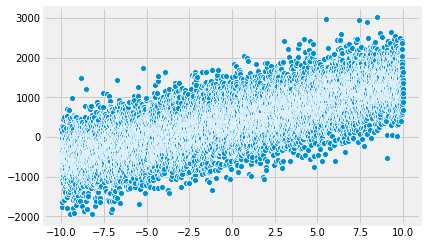

In [12]:
sns.scatterplot(x,y)

That’s a line with intercept b0, slope b1, and a bunch of noise added in.

Now let’s assume we know b0 but want to figure out b1. A simple thing to do is “enumerate” values of b1 and see how they do on the residual sum of squares:

In [13]:
b1seq = np.linspace(0.5*b1, b1*1.5, num=100)

one = np.ones(len(b1seq))  # this is going to be useful in making a matrix of estimates

We're about to make a matrix of residuals for each candidate b1 value.  

First, we'll make y_tile, a matrix where each column is the same replication of the original y values.

In [17]:
y_tile = np.tile(y, (len(b1seq),1))

Now we'll make y_est, a matrix where each column is the estimated y values for each candidate b1.  

To do this we'll use the outer product, which creates a matrix with products for each possible combination of elements.  

In [25]:
y_est = b0 + np.outer(b1seq,x)  # the "outer" product is the opposite of the "inner" product.

Note that I just added b0 directly because I’m assuming it’s known.


Now we’re going to make a matrix of residuals squared. Rows correspond to each enumerated b1 value, and columns correspond to residuals for each individual estimate of y. 

In [27]:
ResidSquareMatrix = (y_tile-y_est)**2
#MSE = (((y_tile - y_est)**2)).sum(axis = 0)/len(x)

Now let’s get a vector of residual *sums* of squares. Each entry in the vector is an RSS for each estimate of b1:

In [30]:
RSS = np.sum(ResidSquareMatrix, axis = 1)

If we plot RSS vs b1 we’ll see how well each enumarated value of b1 performs wrt RSS.  

What do you think the plot will look like?

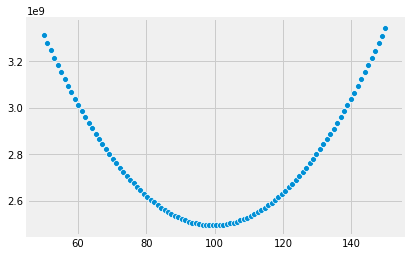

In [32]:
sns.scatterplot(b1seq, RSS)

This shows us that the RSS is minimized at nearly 100. That’s what we’d hope for.

## Distribution of coefficient estimates
Now we're going to estimate coefficients from a subset of the entire data set.  

We want to fit a linear model to the data.  Before we can we need to load scikit-learn, the library that gives us machine learning tools.

In [44]:
from sklearn import linear_model

Let's test the idea by first grabbing one sample.

In [46]:
np.reshape?

In [47]:
sample_n = 2000
np.random.seed(1) # setting the random seed makes notebook runs repeatable.  

# the next line gives n uniformly distributed numbers between 0 and ndata
indx = np.random.randint(low=0, high = ndata, size = sample_n)

xsample = x[indx].reshape(-1,1) # the linear model from scikit learn needs this form
ysample = y[indx].reshape(-1,1) # the linear model from scikit learn needs this form

The way we build models with scikit learn is to first define an object that has the general model characteristics we desire.  Here what we want is a linear model

In [49]:
first_lm = linear_model.LinearRegression()

Then to fit the model to data we do the following:

In [52]:
lm_fit = first_lm.fit(xsample, ysample)

print('The intercept is',lm_fit.intercept_,'and the slope is', lm_fit.coef_[0])

The intercept is [412.41889199] and the slope is [98.83812716]


That gives us one estimate of the coefficients from a single sample.  For the choice of random seed above, the coefficients are close to the "true" ones, but certainly not equal.

Let's see what that distribution of coefficients looks like if we repeatedly sample from the population of data x and y.

First we initialize arrays to store data:

In [61]:
number_samples = 10000

# the next lines initialize vectors to store all the values we're about to create.
b0hat = np.zeros(number_samples)  
b1hat = np.zeros(number_samples)  
RSE = np.zeros(number_samples) 
SEb0 = np.zeros(number_samples) 
SEb1 = np.zeros(number_samples) 
CIb0 = np.zeros((number_samples,2))
CIb1 = np.zeros((number_samples,2))

Now we'll define functions for the RSE and standard errors:

In [62]:
def ResidSE(x, y, n, lm):
    return np.sqrt(np.sum((lm.predict(x) - y)**2)/(n-2))

def StandErr_b0(RSE, n, x):
    xbar = np.mean(x)
    return np.sqrt(RSE**2*(1/n + xbar**2/np.sum((x - xbar)**2)))

def StandErr_b1(RSE, n, x):
    xbar = np.mean(x)
    return np.sqrt(RSE**2*(1/np.sum((x - xbar)**2)))

Then run though a loop to estimate the model many times.  For each estimate we record the coefficients, standard errors, and 95% confidence intervals for the coefficients.  

In [63]:
for i in np.arange(0,number_samples):
    # next line gives n uniformly distributed numbers between 0 and ndata
    indx = np.random.randint(low=0, high = ndata, size = sample_n)
    
    # get the samples:
    xsample = x[indx].reshape(-1,1) # the linear model from scikit learn needs this form
    ysample = y[indx].reshape(-1,1) # the linear model from scikit learn needs this form

    # fit the model and record coefficients
    lm_fit = first_lm.fit(xsample, ysample)
    b0hat[i] = lm_fit.intercept_
    b1hat[i] = lm_fit.coef_[0]
    
    # compute the residual standard error (required for computing coefficient S.E.)
    RSE[i] = ResidSE(xsample, ysample, sample_n, lm_fit)
    #np.sqrt(np.sum((lm_fit.predict(xsample) - ysample)**2)/(sample_n-2))
    
    # compute coefficient S.E.
    SEb0[i] = StandErr_b0(RSE[i], sample_n, x)
    SEb1[i] = StandErr_b1(RSE[i], sample_n, x)
    
    # compute 95% confidence intervals.
    CIb0[i,:] = [b0hat[i]-2*SEb0[i], b0hat[i]+2*SEb0[i]]
    CIb1[i,:] = [b1hat[i]-2*SEb1[i], b1hat[i]+2*SEb1[i]]

Now let's look at the coefficients.  

What is the largest and smallest likely value for each?  What do you think the average value of the distributions will be?

In [64]:
[np.min(b0hat), np.mean(b0hat), np.max(b0hat)]

[361.85015776460455, 404.7930287583703, 444.8653842298346]

In [65]:
[np.min(b1hat), np.mean(b1hat), np.max(b1hat)]

[91.1616652678503, 99.52428912813289, 108.669744071941]

Those average values are mighty close to the actual.  But the range is really big!  

Let's look at the distribution:

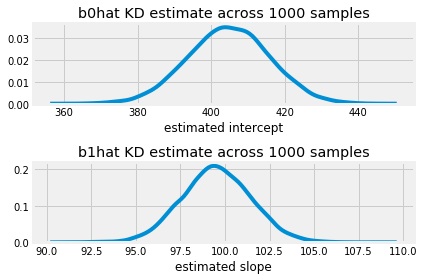

In [66]:
plt.subplot(2,1,1)

sns.kdeplot(b0hat)

plt.xlabel('estimated intercept')
plt.title('b0hat KD estimate across 10000 samples')

plt.subplot(2,1,2)

sns.kdeplot(b1hat)

plt.xlabel('estimated slope')
plt.title('b1hat KD estimate across 10000 samples')
plt.tight_layout()

Now here is the challenge question.  How many times do you expect the true value will be outside the 95% confidence interval for each model?

In [ ]:
b0_below = np.greater(CIb0[:,0], b0) # true if true value below C.I.
b0_above = np.less(CIb0[:,1], b0) # true if true value above C.I.

b0_out_of_CI = np.logical_or(b0_below, b0_above) # true if either is true (i.e. it's outside)

print(...) # number of confidence intervals that don't contain original value

The fraction of estimates outside the 95% CI is

In [ ]:
...

In [ ]:
b1_below = np.greater(CIb1[:,0], b1) # true if true value below C.I.
b1_above = np.less(CIb1[:,1], b1) # true if true value above C.I.

b1_out_of_CI = np.logical_or(b1_below, b1_above) # true if either is true (i.e. it's outside)

sum(b1_out_of_CI)/number_samples # fraction of confidence intervals that don't contain original value

## R$^2$
First let's compute the Rsquared for the last sample: